In [ ]:
%pip install torchvision

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 23.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   --- ------------------------------------ 18.6/212.5 MB 90.4 MB/s eta 0:00:03
   ------- -------------------------------- 39.8/212.5 MB 97.5 MB/s eta 0:00:02
   ----------- --------------------------- 62.9/212.5 MB 100.2 MB/s eta 0:00:02
   --------------- ------------------------ 81.3/212.5 MB 97.8 MB/s eta 0:00:02
   ----------------- ---------------------- 90.7/212.5 MB 86.4 MB/s eta 0:00:02
   ------------------ --------------------- 98.3/212.5 MB 78.4 MB/s eta 0:00:02
   ------------------- ------------------- 106.7/212.5 MB 72.5 MB/s eta 0:00:02
   --------------------- ----------------- 115.3/212.5 MB 68.2 MB/s eta 0:00:02
   ---------------------- ---------------- 123.5/212.5 MB 65.2 MB/s eta 0:00:02
   ------------------------ -------------- 132.1/212.5 MB 63.0 

In [4]:
from torchvision import datasets
import torch
data_folder = 'datasets'
fmnist = datasets.FashionMNIST(data_folder, train=True, download=True)

100.0%
100.0%
100.0%
100.0%


In [5]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [6]:
import matplotlib.pyplot as plt
import numpy as np

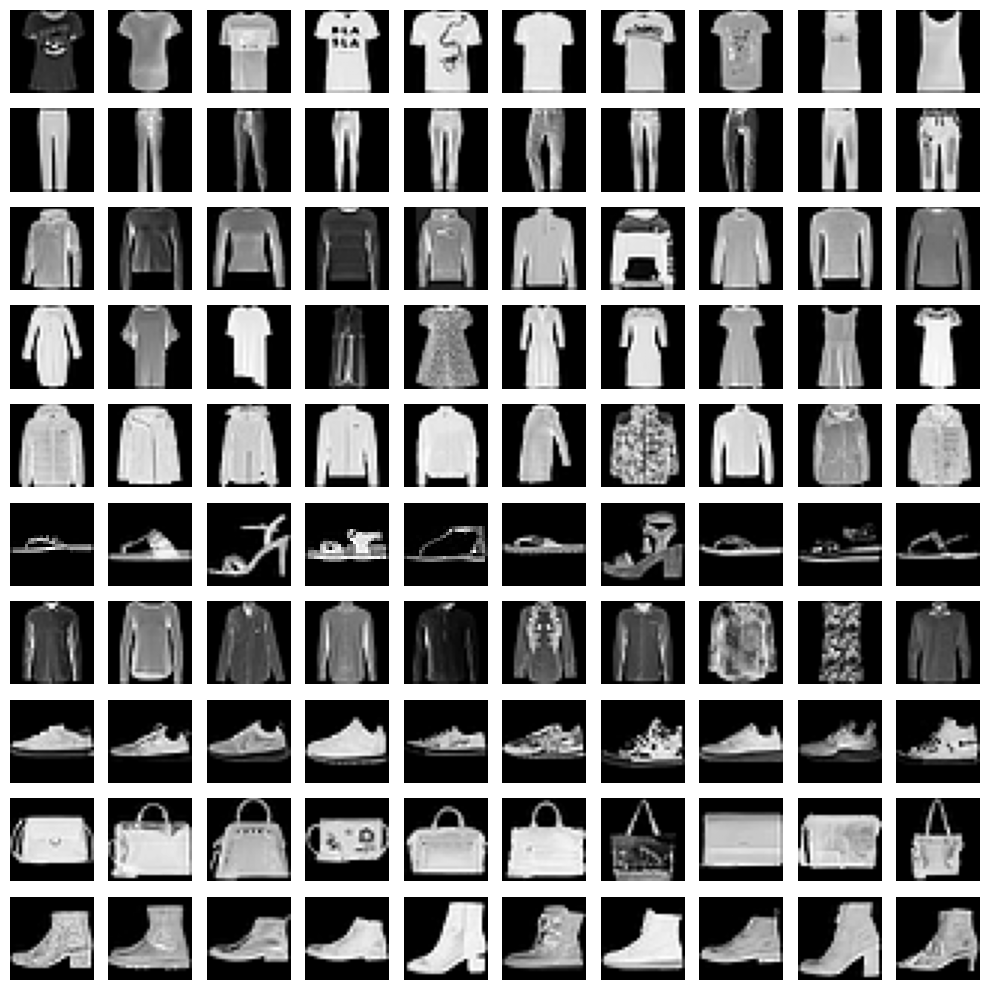

In [ ]:
# A função abaixo exibe 10 imagens de cada classe do dataset Fashion MNIST.

R, C = len(tr_targets.unique()), 10
fig, axes = plt.subplots(R, C, figsize=(C, R))
for labels_class, plot_row in enumerate(axes):
    labels_x_rows = np.where(tr_targets == labels_class)[0]
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(labels_x_rows)
        x, y = tr_images[ix], tr_targets[ix]
        plot_cell.imshow(x, cmap='gray')
plt.tight_layout()

In [8]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision import datasets

In [ ]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1, 28*28) # Aplicando o flattening para cada imagem
        self.x, self.y = x, y
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x,y = self.x[idx], self.y[idx]
        return x.to(device), y.to(device)

In [10]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

# Treinando o Modelo

In [11]:
from torch.optim import SGD
def get_model():
    model = nn.Sequential(
            nn.Linear(28*28, 1000), # Flattening
            nn.ReLU(),
            nn.Linear(1000, 10)
        ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [15]:
@torch.no_grad()
def accuracy(x,y, model):
    model.eval()
    predictions = model(x)
    max_values, argmaxes = predictions.max(-1)
    is_correct = argmaxes == y
    acc = is_correct.numpy().mean()
    return acc.item()

In [13]:
def train_branch(x,y,model,opt,loss_fn):
    model.train()
    predictions = model(x)
    loss = loss_fn(predictions, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [16]:
trn_dl = get_data()
model, loss_fn, opt = get_model()

In [19]:
losses, accs = [], []
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accs = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        loss = train_branch(x,y,model,opt,loss_fn)
        epoch_losses.append(loss)
    epoch_losses = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x,y,model)
        epoch_accs.append(is_correct)
    epoch_accs = np.mean(epoch_accs)
    losses.append(epoch_losses)
    accs.append(epoch_accs)

0
1
2
3
4


C:\Users\guilh\AppData\Local\Temp\ipykernel_11516\356505403.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


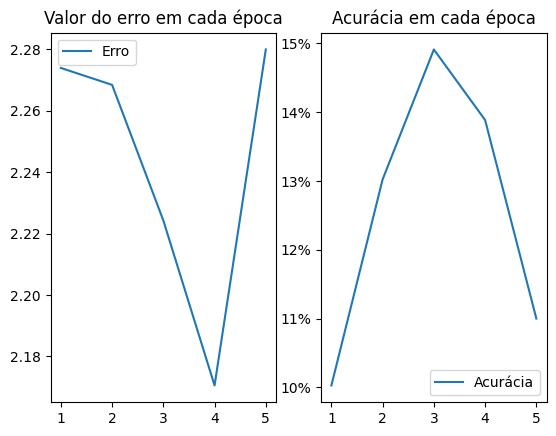

In [20]:
epoch = np.arange(5)+1
plt.Figure(figsize=(20,5))
plt.subplot(121)
plt.title('Valor do erro em cada época')
plt.plot(epoch, losses, label='Erro')
plt.legend()
plt.subplot(122)
plt.title('Acurácia em cada época')
plt.plot(epoch, accs, label='Acurácia')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()